In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import collections

for fn in os.listdir('series_data'):
    
    if '.tsv' in fn:
        print(fn)
        with open(f"series_data/{fn}", "r") as f:
            df = pd.read_csv(f, sep='\t', index_col=None)
            plot_loss_spike(df, fn)

gpt-760m-weight-tying-LczKSX.tsv
Found loss spike at batch 16709.0
gpt-125m-baseline-0IsGnQ.tsv
Found loss spike at batch 18093.0
gpt-125m-lr6e-4-JejH1w.tsv
Found loss spike at batch 26020.0
gpt-350m-baseline-zLmNQJ.tsv
gpt-1b-baseline-optimizer-monitor-ToI9ex.tsv
Found loss spike at batch 14170.0
gpt-350m-egs-vg1ACI.tsv
Found loss spike at batch 27888.0
gpt-350m-baseline-raise-lr-sU0C1z.tsv
Found loss spike at batch 29805.0
gpt-760m-baseline-qmJfdR.tsv
Found loss spike at batch 13273.0
gpt-760m-baseline.tsv
gpt-760m-baseline-wd1-5-ZvlB9f.tsv
Found loss spike at batch 42034.0
gpt-760m-baseline-wd1-5-gcnorm-0-5-ibVKXw.tsv
gpt-1b-baseline-egs0-1-0Y0ODb.tsv
Found loss spike at batch 24607.0
gpt-3b-baseline-fScZNa.tsv
Found loss spike at batch 15633.0
gpt-125m-wd1-5-gcnorm-0-5-W8uRk6.tsv
Found loss spike at batch 20129.0
gpt-125m-lower-lr-FgBxJT.tsv
Found loss spike at batch 10401.0
gpt-7b-egs-0-1-4KeMve.tsv
branching-gpt-760m-YrxVTk.tsv
Found loss spike at batch 7176.0


<Figure size 640x480 with 0 Axes>

In [6]:
def plot_loss_spike(df, fn):
    lsd = LossSpikeDetector(window_moving_average=25,
                 loss_increase_factor=2,
                 loss_increase_lookback=1000,
                 loss_plateau_min_duration=200,
                 end_loss_spike_factor=1.10)
    
    spike = None
    for index, row in df.iterrows():
        batch, loss = row['trainer/batch_idx'],row['loss/train/total']
        if lsd.insert_observation(loss, batch):
            spike = batch
            print(f"Found loss spike at batch {batch}")
            break

    plt.plot(df['trainer/batch_idx'],df['loss/train/total'])
    if spike is not None:
        plt.vlines(batch-200, 0, 12, color='red',  linestyles ="dotted")
    plt.savefig(f"pictures/{fn.split('.')[0]}.png")
    plt.clf()


In [81]:
df

,loss/train/total,trainer/batch_idx,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.15._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.23._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.19._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.7._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.8._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.16._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.3._fsdp_wrapped_module.flat_param,l2_norm/update/model._fsdp_wrapped_module._fpw_module.transformer.blocks.9._fsdp_wrapped_module.flat_param,...,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.16._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.19._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.2._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.0._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.14._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.13._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.4._fsdp_wrapped_module.flat_param,cosine/update_grad/model._fsdp_wrapped_module._fpw_module.transformer.blocks.6._fsdp_wrapped_module.flat_param,m_params
0,11.115813,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1315
1,11.100040,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1315
2,11.060068,2,0.002645,0.002535,0.002466,0.002828,0.002836,0.002591,0.003020,0.002783,...,0.318633,0.273568,0.094157,0.406082,0.427921,0.334112,0.319058,0.403908,0.344219,1315
3,9.886762,3,0.005116,0.004928,0.004755,0.005493,0.005497,0.005017,0.005879,0.005422,...,0.290369,0.250325,0.073357,0.382469,0.445007,0.309038,0.297500,0.380038,0.329526,1315
4,9.690895,4,0.007051,0.006724,0.006555,0.007461,0.007419,0.006882,0.007865,0.007427,...,0.254762,0.232145,0.139242,0.356648,0.333109,0.272723,0.273088,0.301154,0.295693,1315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20077,7.134404,20077,0.000057,0.000018,0.000023,0.000137,0.000057,0.000038,0.012964,0.000075,...,0.138180,0.071335,0.161158,-0.126108,0.317478,0.199201,0.207233,0.309628,0.490504,1315
20078,7.444552,20078,0.000057,0.000018,0.000023,0.000141,0.000059,0.000039,0.015842,0.000074,...,0.231360,0.147025,0.187588,0.378731,0.415000,0.392347,0.342447,0.285212,0.731376,1315
20079,7.443802,20079,0.000054,0.000017,0.000022,0.000135,0.000056,0.000037,0.015313,0.000071,...,0.096482,0.053468,0.152388,0.094535,0.300878,0.158839,0.126262,0.148623,0.307047,1315
20080,7.534973,20080,0.000051,0.000016,0.000021,0.000128,0.000053,0.000035,0.013628,0.000066,...,0.086229,0.051142,0.079789,0.370165,0.232678,0.127114,0.112635,0.134144,0.213204,1315


In [5]:
class LossSpikeDetector:
    
    def __init__(self,
                 window_moving_average=25,
                 loss_increase_factor=1.5,
                 loss_increase_lookback=500,
                 loss_plateau_min_duration=1000,
                 end_loss_spike_factor=1.15):
          
        self.window_moving_average=window_moving_average
        self.loss_increase_factor=loss_increase_factor
        self.loss_plateau_min_duration=loss_plateau_min_duration
        self.loss_increase_lookback = loss_increase_lookback
        self.fast_moving_average = collections.deque(maxlen=window_moving_average)
        self.intermediate_data_queue = collections.deque(maxlen=loss_increase_lookback-window_moving_average)
        self.slow_moving_average = collections.deque(maxlen=loss_increase_lookback)
        self.end_loss_spike_factor = end_loss_spike_factor
        self.in_loss_spike = False
        self.loss_mva_before_spike = None
        self.loss_spike_batch_idx_start = None


    
    def insert_observation(self, loss_obs, batch_idx):
        if len(self.fast_moving_average) >= self.fast_moving_average.maxlen:
            # move the oldest obs out of the fast moving average into the
            # intermediate data queue
            fast_obs = self.fast_moving_average.popleft()
            
            if len(self.intermediate_data_queue) >= self.intermediate_data_queue.maxlen:
                # move data from intermediate quque to slow MCVA queue
                intermediate_obs = self.intermediate_data_queue.popleft()
                self.slow_moving_average.append(intermediate_obs)

            self.intermediate_data_queue.append(fast_obs)
        
        self.fast_moving_average.append(loss_obs)
        
        fast_mva = sum(self.fast_moving_average) / len(self.fast_moving_average)
        if not self.in_loss_spike:
            if len(self.slow_moving_average) > self.window_moving_average:
                if self.loss_mva_before_spike is None:
                    slow_mva = sum(self.slow_moving_average) / len(self.slow_moving_average)
                else:
                    slow_mva = self.loss_mva_before_spike
                                    
                
                if fast_mva >= self.loss_increase_factor * slow_mva:
                    self.in_loss_spike = True
                    self.loss_mva_before_spike = slow_mva
                    self.loss_spike_batch_idx_start = batch_idx
        else:
            if batch_idx - self.loss_spike_batch_idx_start > self.loss_plateau_min_duration:
                # kill the run!
                return True
            else:
                if fast_mva <= self.loss_mva_before_spike * self.end_loss_spike_factor:
                    self.in_loss_spike = False
                    self.loss_spike_batch_idx_start = None
        
        return False
            
    
    


In loss spike
In loss spike
Found loss spike at batch 16138.0


Found loss spike at batch 14170.0


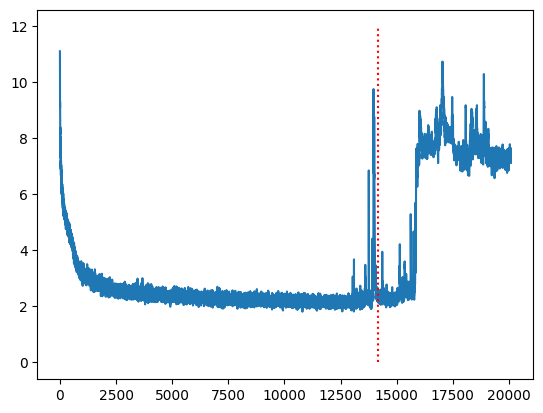

In [23]:
d.popleft()

2